# EthicalTips Classification

Scott Atkinson

## [0. Contents](#0.)<a id='0.'></a>

* ### [0.0. Load libraries](#0.0.)
    
## [1. Load and wrangle data](#1.)

## [2. EDA](#2.)

* ### [2.0. Word frequency](#2.0.)
* ### [2.1. Reading level](#2.1.)
* ### [2.2. Clustering topics](#2.2.)

## [3. Preprocessing](#3.)

* ### [3.0. Bag-of-words preprocessing](#3.0.)
* ### [3.1. Finding best vectorizer](#3.1.)
* ### [3.2. Most predictive words: title](#3.2.)

## [4. Modeling](#4.)

* ### [4.0. Cross-validation](#4.0.)
* ### [4.1. Threshold tuning](#4.1.)

## [5. Model production](#5.)

* ### [5.0. Saving relevant files](#5.0.)
* ### [5.1. Script for prediction function](#5.1.)


### 0.0. Load libraries<a id='0.0.'></a>

In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from wordcloud import WordCloud

from scipy.sparse import hstack, coo_matrix, csr_matrix

import textstat

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, fbeta_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import pickle


plt.rcParams['figure.figsize'] = [13, 13]
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

<ipython-input-1-9eeff0bfeb06>:34: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## 1. Load and wrangle data<a id='1.'></a>

In [2]:
lpt = pd.read_csv('lpt_raw.csv')
lpt.drop('Unnamed: 0', axis=1, inplace=True)
lpt.drop_duplicates(subset=['title'], inplace=True)
ulpt = pd.read_csv('ulpt_raw.csv')
ulpt.drop('Unnamed: 0', axis=1, inplace=True)
ulpt.drop_duplicates(subset=['title'], inplace=True)

pt_list = [lpt,ulpt]
text_list = ['title','selftext']

for i in range(2):
    # select relevant columns

    pt_list[i] = pt_list[i][['subreddit','title','id','created_utc','score','num_comments','selftext']]

    # pass 'created_utc' to datetime

    pt_list[i]['created_utc'] = pd.to_datetime(pt_list[i]['created_utc'], unit='s')

    # save raw title text for reading level analysis
    
    pt_list[i]['title_raw'] = pt_list[i]['title'].copy()
    
    for text_col in text_list:
        
        # convert 'title' and 'selftext' to lowercase
        
        pt_list[i][text_col] = pt_list[i][text_col].str.lower()

        # remove punctuation from 'title' and 'selftext'
        
        for j in pt_list[i].index:
            s = pt_list[i].loc[j,text_col]
            if s == s:
                # remove punctuation
                pt_list[i].loc[j,text_col] = re.sub(r'[^\w\s]','',s)
                # remove opening/trailing whitespace
                pt_list[i].loc[j,text_col] = pt_list[i].loc[j,text_col].strip()
                


In [3]:
lpt = pt_list[0]
ulpt = pt_list[1]

In [4]:
lpt.head()

,subreddit,title,id,created_utc,score,num_comments,selftext,title_raw
0,LifeProTips,lpt if youre still drinking by the time your friends leave the bar go home,kqrgt7,2021-01-05 05:25:11,1,1,this applies a lot more to people who either drink very casually or are new to social drinking i dont have the experience decades would provide but as a 3rd year college student ive been there and seen enough nothing good ever comes of it when your friends leave this is generally a good indicator to slow down for a bit and please always get a ride if not with them,"LPT: If you're still drinking by the time your friends leave the bar, go home."
1,LifeProTips,lpt if youre driving and another car is following you and you know the other driver has road rage do not go home giving a person who intends to harm you your address to you your property and your family is never a good idea instead ask your gps for directions to the neared police station,kqreyi,2021-01-05 05:21:55,1,1,heres an example of what im talking abouthttpswwwyoutubecomwatchvjkxi_nea9p4ampt9s\n\nsomething similar happened to me i had a disagreement at the home depot parking lot the guy followed me to my house and he did the finger across his neck thing and drove away\n\non your way to the station grab as much information about the car and driver how illegal tailing you with road rage is a grey area but it cant hurt to give the cops enough info more importantly the sight of you pulling into the police station should deter them from following you regardless if the police will pursue it file a report be safe also do not escalate a road rage incident its not worth it,"LPT: If you're driving and another car is following you and you know the other driver has road rage do not go home. Giving a person who intends to harm you your address to you, your property, and your family is never a good idea. Instead ask your GPS for directions to the neared police station."
2,LifeProTips,lpt if you have a stuffy nose try pressing the spot between your eyebrows with your finger while pushing the roof of your mouth with your tongue for 2030 seconds,kqrewb,2021-01-05 05:21:48,1,1,NaN,"LPT: If you have a stuffy nose, try pressing the spot between your eyebrows with your finger while pushing the roof of your mouth with your tongue for 20-30 seconds."
3,LifeProTips,lpt make a habit of switching on the oven light every time you heat it up youll be less likely to forget to turn it off after cooking,kqr8d1,2021-01-05 05:10:39,1,1,every time i use my oven i switch the oven light on and dont turn it off again until i clear the temperature if you ever forget to turn off the heat this serves as a more obvious visual reminder especially when the environment is darker as you settle in for the night,"LPT: Make a habit of switching on the oven light every time you heat it up, you'll be less likely to forget to turn it off after cooking."
4,LifeProTips,lpt annoying fly in your room shut your curtainsblinds turn off your light and open the door turn on the hallway light and the fly will leave immediately in search of the new light source when you can shut it out,kqr7tb,2021-01-05 05:09:43,1,1,ive been doing this for years its a failsafe strategy for getting rid of flies buzzing around in your room if you cant find the flyhave no armscant reach the flyare a vegan and cant kill the flyetc,"LPT: Annoying fly in your room? Shut your curtains/blinds, turn off your light, and open the door. Turn on the hallway light and the fly will leave immediately in search of the new light source, when you can shut it out."


In [5]:
ulpt.head()

,subreddit,title,id,created_utc,score,num_comments,selftext,title_raw
0,UnethicalLifeProTips,ulpt get dealer plates for your car and you wont have to pay for insurance,kqnc2a,2021-01-05 01:32:39,1,5,this works especially well if the car is for a young driver,ULPT: Get Dealer plates for your car and you won’t have to pay for insurance.
1,UnethicalLifeProTips,ulpt when in a grocery store randomly grab snacks off the shelf and eat them while walking around and nobody will bat an eye,kqmfrq,2021-01-05 00:45:00,1,56,NaN,"ULPT: When in a grocery store, randomly grab snacks off the shelf and eat them while walking around and nobody will bat an eye."
2,UnethicalLifeProTips,ulpt ask the cop when he last calibrated his radar gun,kqijoo,2021-01-04 21:34:03,1,3,if you get pulled over and theres no way youre getting out of it discuss with the prosecutor your options of taking the case in front of a judge \nschedule the date for the furthest possible date if the cop doesnt show youre clear \n\nif the cop does show ask himher when the last time they calibrated their radarlidar gun was \n\ntheyll give you an answer and then ask them if they have the papersgun to prove that they wont have them and the judge will have to throw the case out on insufficientunreliable evidence \n\nsource ive used this 3 times in ks and 4 times in ga,ULPT - Ask the cop when he last calibrated his radar gun.
3,UnethicalLifeProTips,ulpt send nuisance calls to mobile phone,kqided,2021-01-04 21:25:56,1,6,so i was supposed to receive a shopping delivery between 2000 and 2200 but driver never showed up and left a voice message claiming he was outside but no have been sat next to the window and nobody ever came i have since been online and now it says my order is cancelled and when when i try to call driver he is not picking up the phone and now its going to voicemail i a m absolutely fuming he obviously client be arsed to deliver it i want to get him back by sending nuisance and scam calls to his phone i am in england please help,ULPT send nuisance calls to mobile phone
4,UnethicalLifeProTips,ulpt getting banned from subs so they dont pop up on recommended,kqeysy,2021-01-04 18:47:12,1,5,title im sick of seeing my reccomended flooded with rpolitics and read if you get banned it stops is there a way to do it,ULPT - Getting banned from subs so they dont pop up on recommended


In [6]:
df = pd.concat([lpt,ulpt],axis=0)
df = df.reset_index(drop=True)
df = df.dropna(subset=['title'])
df = df[df['title'] != 'lpt']
df = df[df['title'] != 'ulpt']

## drop gg submission

df = df.drop([9007,5550,9791,7880,7047,8350,8349,5037, 7474, 7774, 7981, 8008, 8257, 8275, 8334, 8696, 8728, 8744,
            8760, 8806, 8898, 8938, 8940, 8956, 8992, 9043, 9090, 9565, 9890])

In [7]:
df.head()

,subreddit,title,id,created_utc,score,num_comments,selftext,title_raw
0,LifeProTips,lpt if youre still drinking by the time your friends leave the bar go home,kqrgt7,2021-01-05 05:25:11,1,1,this applies a lot more to people who either drink very casually or are new to social drinking i dont have the experience decades would provide but as a 3rd year college student ive been there and seen enough nothing good ever comes of it when your friends leave this is generally a good indicator to slow down for a bit and please always get a ride if not with them,"LPT: If you're still drinking by the time your friends leave the bar, go home."
1,LifeProTips,lpt if youre driving and another car is following you and you know the other driver has road rage do not go home giving a person who intends to harm you your address to you your property and your family is never a good idea instead ask your gps for directions to the neared police station,kqreyi,2021-01-05 05:21:55,1,1,heres an example of what im talking abouthttpswwwyoutubecomwatchvjkxi_nea9p4ampt9s\n\nsomething similar happened to me i had a disagreement at the home depot parking lot the guy followed me to my house and he did the finger across his neck thing and drove away\n\non your way to the station grab as much information about the car and driver how illegal tailing you with road rage is a grey area but it cant hurt to give the cops enough info more importantly the sight of you pulling into the police station should deter them from following you regardless if the police will pursue it file a report be safe also do not escalate a road rage incident its not worth it,"LPT: If you're driving and another car is following you and you know the other driver has road rage do not go home. Giving a person who intends to harm you your address to you, your property, and your family is never a good idea. Instead ask your GPS for directions to the neared police station."
2,LifeProTips,lpt if you have a stuffy nose try pressing the spot between your eyebrows with your finger while pushing the roof of your mouth with your tongue for 2030 seconds,kqrewb,2021-01-05 05:21:48,1,1,NaN,"LPT: If you have a stuffy nose, try pressing the spot between your eyebrows with your finger while pushing the roof of your mouth with your tongue for 20-30 seconds."
3,LifeProTips,lpt make a habit of switching on the oven light every time you heat it up youll be less likely to forget to turn it off after cooking,kqr8d1,2021-01-05 05:10:39,1,1,every time i use my oven i switch the oven light on and dont turn it off again until i clear the temperature if you ever forget to turn off the heat this serves as a more obvious visual reminder especially when the environment is darker as you settle in for the night,"LPT: Make a habit of switching on the oven light every time you heat it up, you'll be less likely to forget to turn it off after cooking."
4,LifeProTips,lpt annoying fly in your room shut your curtainsblinds turn off your light and open the door turn on the hallway light and the fly will leave immediately in search of the new light source when you can shut it out,kqr7tb,2021-01-05 05:09:43,1,1,ive been doing this for years its a failsafe strategy for getting rid of flies buzzing around in your room if you cant find the flyhave no armscant reach the flyare a vegan and cant kill the flyetc,"LPT: Annoying fly in your room? Shut your curtains/blinds, turn off your light, and open the door. Turn on the hallway light and the fly will leave immediately in search of the new light source, when you can shut it out."


In [8]:
# define function for removing LPT and ULPT from text
def remove(s):
    if s == s:
        if 'ulpt' in s:
            return s.replace('ulpt','')
        elif 'lpt' in s:
            return s.replace('lpt','')
        else:
            return s
    else:
        return ''

In [9]:
# function to process data

def process(data):
    #apply twice since some posts contain two instances

    data['title'] = data['title'].apply(remove).apply(remove)
    data['selftext'] = data['selftext'].apply(remove).apply(remove)

    # remove the word unethical from titles and selftexts

    for i in data.index:
        while 'unethical' in data.loc[i,'title']:
            data.loc[i,'title'] = data.loc[i,'title'].replace('unethical','')
        while 'unethical' in data.loc[i,'selftext']:
            data.loc[i,'selftext'] = data.loc[i,'selftext'].replace('unethical','')

    data['alltext'] = ''
    for i in data.index:
        selftext = data.loc[i,'selftext']
        if selftext == selftext:
            data.loc[i,'alltext'] = data.loc[i,'title'] + ' ' + data.loc[i,'selftext']
        else:
            data.loc[i,'alltext'] = data.loc[i,'title']

    data = data.drop_duplicates(subset='title')

In [10]:
process(df)

In [11]:
lpt = df[df['subreddit']=='LifeProTips']
ulpt = df[df['subreddit']=='UnethicalLifeProTips']

## 2. EDA<a id='2.'></a>

### 2.0. Word frequency<a id='2.0.'></a>

In [12]:
def word_count(word):
    lpt_freq = df[df['subreddit'] == 'LifeProTips'].title.str.contains(word).sum()
    ulpt_freq = df[df['subreddit'] == 'UnethicalLifeProTips'].title.str.contains(word).sum()
#     print('LPT Frequencey of %s: '%(word), lpt_freq)
#     print('ULPT Frequencey of %s: '%(word), ulpt_freq, '\n')
    return lpt_freq, ulpt_freq

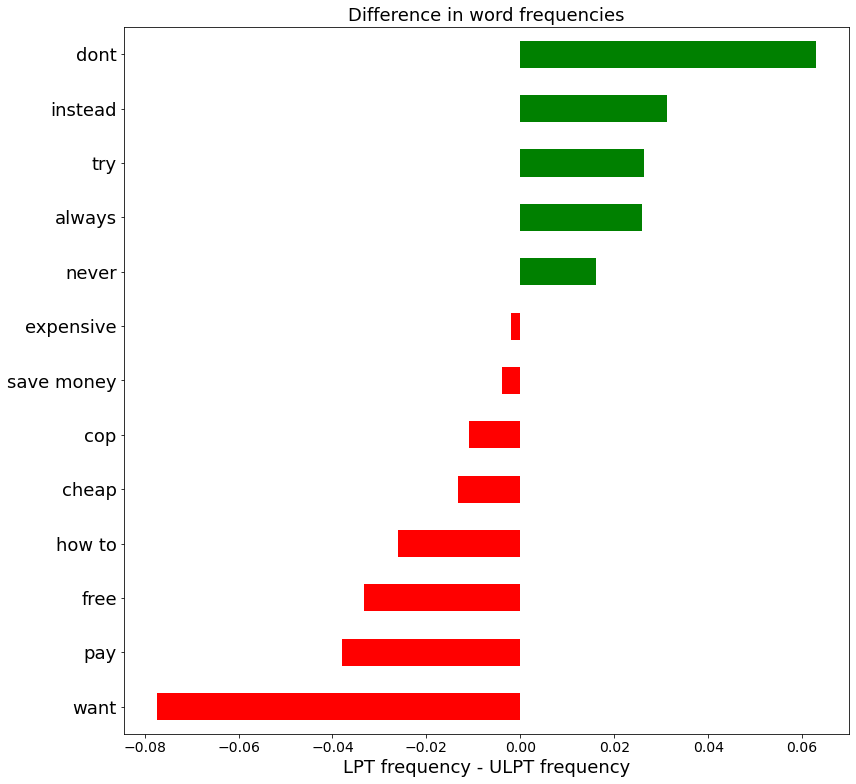

In [13]:
words = ['free',
         'dont',
         'want',
         'pay',
         'cop',
         'try',
         'expensive',
         'cheap',
         'save money',
         'instead',
         'never',
         'always',
         'how to'
        ]

word_count_list = [word_count(word) for word in words]
differences = np.array([(a-b)/5000 for a,b in word_count_list])
words_df = pd.DataFrame(differences,index=words, columns=['diff'])
words_df['positive'] = words_df['diff']>0
words_df = words_df.sort_values('diff')

words_df['diff'].plot(kind = 'barh', color=words_df.positive.map({True: 'g', False: 'r'}))
plt.title('Difference in word frequencies', fontsize=18)
plt.xlabel('LPT frequency - ULPT frequency', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.savefig('Report/prelim_word_freq.jpeg')
plt.show()

### 2.1. Reading level<a id='2.1.'></a>

Examine reading level for `alltext`.

In [14]:
#use original title to allow punctuation to accurately reflect sentence count

df['title_reading_level'] = df['title_raw'].apply(textstat.flesch_kincaid_grade)

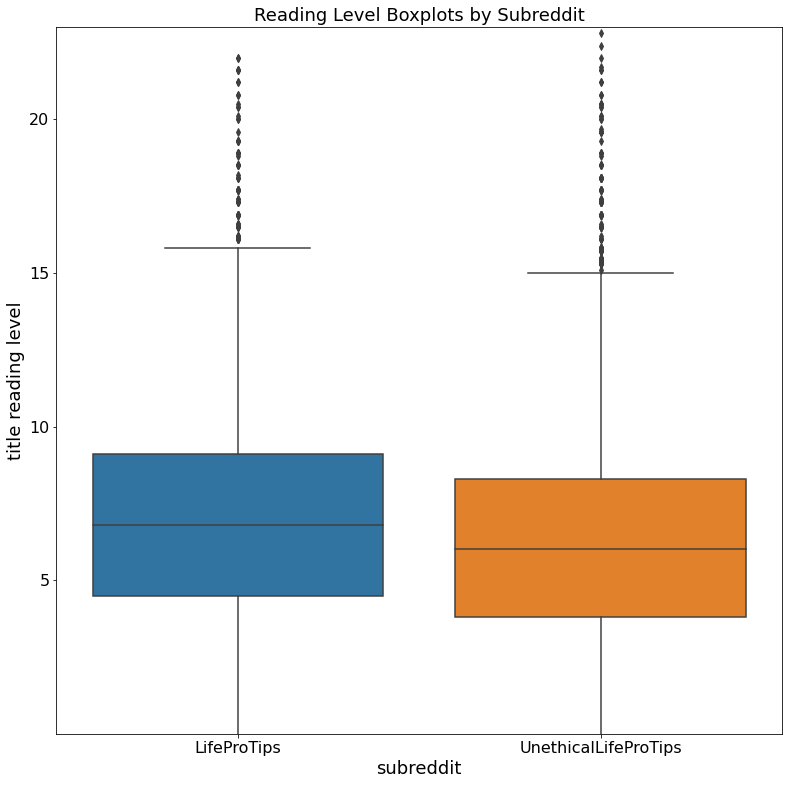

In [15]:
# box plot for LPT reading level
sns.boxplot(x='subreddit', y='title_reading_level', data=df)
plt.ylim([0,23])
plt.xlabel('subreddit',fontsize=18)
plt.ylabel('title reading level', fontsize=18)
plt.title('Reading Level Boxplots by Subreddit',fontsize=18)
plt.xticks(ticks=[0,1],labels=['LifeProTips','UnethicalLifeProTips'],fontsize=16)
plt.yticks(ticks=[5,10,15,20],labels=[5,10,15,20],fontsize=16)
plt.savefig('Report/readinglevel_boxplot.jpeg')
plt.show()


In [16]:
df[df['subreddit']=='LifeProTips'].title_reading_level.describe()

count    4945.000000
mean     7.002851   
std      3.578326   
min     -3.100000   
25%      4.500000   
50%      6.800000   
75%      9.100000   
max      22.000000  
Name: title_reading_level, dtype: float64

In [17]:
df[df['subreddit']=='UnethicalLifeProTips'].title_reading_level.describe()

count    4926.000000
mean     6.353613   
std      3.839763   
min     -3.500000   
25%      3.800000   
50%      6.000000   
75%      8.300000   
max      41.000000  
Name: title_reading_level, dtype: float64

### 2.2. Clustering topics<a id='2.2.'></a>

Function to tokenize and perform lemmatization

In [18]:
def tok_lem(data):
    lemmatizer = WordNetLemmatizer()
    for i in data.index:
        text = data.loc[i]
        tokenized = word_tokenize(text)
        lemma = [lemmatizer.lemmatize(word) for word in tokenized]
        lemmatized_text = ' '.join(lemma)
        data.loc[i] = lemmatized_text

### ULPT Title

In [19]:
ulpt_title = ulpt['title']
tok_lem(ulpt_title)

ulpt_vectorizer = CountVectorizer(min_df=20, stop_words='english')
ulpt_cv = ulpt_vectorizer.fit_transform(ulpt_title)

In [20]:
n_components =8

lda_ulpt = LatentDirichletAllocation(n_components=n_components, max_iter=10, learning_method='online', random_state=31)


ulpt_dist = pd.DataFrame(lda_ulpt.fit_transform(ulpt_cv), index=ulpt.index)

ulpt_lda_scores = ulpt.join(ulpt_dist,how='inner')

for i in range(n_components):
    print('ULPT Topic %s:\n'%(i))
    print(ulpt_lda_scores.sort_values(i,ascending=False)['title'].head(8), '\n')

ULPT Topic 0:

4974    if you have to cancel a nonrefundable hotel room last minute cancel it then immediately buy the cancellable version of the room tell the hotel that you accidentally canceled the room and made another reservation they will refund you for the first room then you can cancel the new room
5005    wan na pay low price for everything find a 1 item in any physical store and take the barcode go to self checkout and slio the barcode in front of the item you dont wan na pay much for                                                                                                     
4954    sell expensive electronics on ebay purchase shipping insurance and then intentionally do a poor job packaging the item for shipping you can get paid twice for the same item                                                                                                                
5423    purchase limit on essential item that sell out quick hide them throughout the store before they se

### LPT Title

In [21]:
lpt_title = lpt['title']
tok_lem(lpt_title)

lpt_vectorizer = CountVectorizer(min_df=20, stop_words='english')
lpt_cv = lpt_vectorizer.fit_transform(lpt_title)

In [22]:
n_components =8

lda_lpt = LatentDirichletAllocation(n_components=n_components, max_iter=10, learning_method='online', random_state=5)



lpt_dist = pd.DataFrame(lda_lpt.fit_transform(lpt_cv), index=lpt.index)

lpt_lda_scores = lpt.join(lpt_dist,how='inner')

for i in range(n_components):
    print('LPT Topic %s:\n'%(i))
    print(lpt_lda_scores.sort_values(i,ascending=False)['title'].head(8), '\n')

LPT Topic 0:

7       get awesome graduation party supply by shopping the clearance section of new year merchandise buy 2021themed good now and put them away for cap and gown celebration
101     if you look up the ps5 on your girlfriend phone shell start getting ad for it and will be more likely to buy it for you                                             
1490    when getting a tattoo dont ever settle based on budget and always try to find an artist that ha done work similar to how you imagine the end result                 
720     if your car wind up stuck in the snow place your floor mat right behind your tire the additional traction will be enough for your car to safely move                
38      when you live in a permanent residence write a date on every appliance or household device you change modify or replace                                             
267     move the playback speed up on youtube video when canvassing a large amount of information 125x is usually perfect

## 3. Preprocessing<a id='3.'></a>

### 3.0. Bag-of-words preprocessing<a id='3.0.'></a>

We vectorize `title` and `selftext` individually so that they can receive separate attention from the classifier.

In [23]:
titles = df['title']
selftexts = df['selftext']
alltext = df['alltext']
reading_level = np.array(df['title_reading_level']).reshape(-1,1)

# Target variable: true corresponds to ULPT
y = df['subreddit'] == 'UnethicalLifeProTips'

In [24]:
tok_lem(titles)
tok_lem(selftexts)

Train test split now to avoid data leakage in vectorizers

In [25]:
# Create mask for training data

itrain, itest = train_test_split(range(df.shape[0]), train_size=0.75, random_state=2)
mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itrain] = True

Produce training and testing data

In [26]:
titles_train = titles[mask]
titles_test = titles[~mask]

selftexts_train = selftexts[mask]
selftexts_test = selftexts[~mask]

alltext_train = df[mask]['alltext']
alltext_test = df[~mask]['alltext']

reading_level_train = np.array(df[mask]['title_reading_level']).reshape(-1,1)
reading_level_test = np.array(df[~mask]['title_reading_level']).reshape(-1,1)

# scaler = StandardScaler()
# reading_level_train = scaler.fit_transform(reading_level_train)
# reading_level_test = scaler.transform(reading_level_test)

reading_level_train = coo_matrix(reading_level_train)
reading_level_test = coo_matrix(reading_level_test)

y_train = y[mask]
y_test = y[~mask]

Find best minimum document frequency for the vectorizer

In [27]:
#the grid of parameters to search over
alphas = [0.01,.1, 1, 5]
t_min_dfs = [10,100]
s_min_dfs = [10,100]
t_bigram_dfs = [10,100]
s_bigram_dfs = [10,100]

#Find the best value for alpha and min_df, and the best classifier
# using countvectorizer
best_alpha = None
best_t_min_df = None
best_s_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for t_min_df in t_min_dfs:
        for s_min_df in s_min_dfs:
            for t_bigram_df in t_bigram_dfs:
                for s_bigram_df in s_bigram_dfs:        
                    t_vectorizer = CountVectorizer(min_df=t_min_df, stop_words='english')
                    s_vectorizer = CountVectorizer(min_df=s_min_df, stop_words='english')
                    t_bigrams = CountVectorizer(min_df=t_bigram_df, stop_words='english', ngram_range=(2,2), max_features=3000)
                    s_bigrams = CountVectorizer(min_df=s_bigram_df, stop_words='english', ngram_range=(2,2), max_features=3000)
                    titletraincv = t_vectorizer.fit_transform(titles_train)
                    titletrainbigram = t_bigrams.fit_transform(titles_train)
                    selftexttraincv = s_vectorizer.fit_transform(selftexts_train)
                    selftexttrainbigram = s_bigrams.fit_transform(selftexts_train)

                    train_matrix = hstack([titletraincv,titletrainbigram,selftexttraincv,selftexttrainbigram])


                    titletestcv = t_vectorizer.transform(titles_test)
                    titletestbigram = t_bigrams.transform(titles_test)
                    selftexttestcv = s_vectorizer.transform(selftexts_test)
                    selftexttestbigram = s_bigrams.transform(selftexts_test)

                    test_matrix = hstack([titletestcv,titletestbigram,selftexttestcv,selftexttestbigram])

                    model = MultinomialNB(alpha)
                    model.fit(train_matrix,y_train)
                    pred = model.predict(test_matrix)

                    score = accuracy_score(y_test,pred)
                    if score > maxscore:
                        maxscore = score
                        best_alpha = alpha
                        best_t_min_df = t_min_df
                        best_s_min_df = s_min_df
                        best_t_bigram_df = t_bigram_df
                        best_s_bigram_df = s_bigram_df
        
print('Best score: ', maxscore)
print('Best alpha: ', best_alpha)
print('Best t_min_df: ', best_t_min_df)
print('Best s_min_df: ', best_s_min_df)
print('Best t_bigram_df: ', best_t_bigram_df)
print('Best s_bigram_df: ', best_s_bigram_df)

Best score:  0.7759319286871961
Best alpha:  0.1
Best t_min_df:  10
Best s_min_df:  10
Best t_bigram_df:  10
Best s_bigram_df:  10


### 3.1. Finding best vectorizer<a id='3.1.'></a>

`title` and `selftext`:

In [28]:
t_vectorizer = CountVectorizer(min_df=best_t_min_df, stop_words='english')
s_vectorizer = CountVectorizer(min_df=best_s_min_df, stop_words='english')
t_bigrams = CountVectorizer(min_df=best_t_bigram_df, stop_words='english', ngram_range=(2,2), max_features=3000)
s_bigrams = CountVectorizer(min_df=best_s_bigram_df, stop_words='english', ngram_range=(2,2), max_features=3000)
titletraincv = t_vectorizer.fit_transform(titles_train)
titletrainbigram = t_bigrams.fit_transform(titles_train)
selftexttraincv = s_vectorizer.fit_transform(selftexts_train)
selftexttrainbigram = s_bigrams.fit_transform(selftexts_train)


train_matrix = hstack([titletraincv,titletrainbigram,selftexttraincv,selftexttrainbigram])


titletestcv = t_vectorizer.transform(titles_test)
titletestbigram = t_bigrams.transform(titles_test)
selftexttestcv = s_vectorizer.transform(selftexts_test)
selftexttestbigram = s_bigrams.transform(selftexts_test)

test_matrix = hstack([titletestcv,titletestbigram,selftexttestcv,selftexttestbigram])

model = MultinomialNB(best_alpha)
model.fit(train_matrix,y_train)
pred = model.predict(test_matrix)



score = accuracy_score(y_test,pred)
cm = confusion_matrix(y_test,pred)
auc = roc_auc_score(y_test,pred)
print('accuracy: ', score)
print('roc_auc_score: ', auc)
print(cm)

accuracy:  0.7759319286871961
roc_auc_score:  0.7760743690119922
[[918 321]
 [232 997]]


`title` and `selftext` without bigrams

In [29]:
t_vectorizer = TfidfVectorizer(min_df=10, stop_words='english')
s_vectorizer = TfidfVectorizer(min_df=10, stop_words='english')

titletraincv = t_vectorizer.fit_transform(titles_train)
selftexttraincv = s_vectorizer.fit_transform(selftexts_train)

train_matrix = hstack([titletraincv,selftexttraincv])

titletestcv = t_vectorizer.transform(titles_test)
selftexttestcv = s_vectorizer.transform(selftexts_test)

test_matrix = hstack([titletestcv,selftexttestcv])

model = MultinomialNB(best_alpha)
model.fit(train_matrix,y_train)
pred = model.predict(test_matrix)



score = accuracy_score(y_test,pred)
cm = confusion_matrix(y_test,pred)
auc = roc_auc_score(y_test,pred)
print('accuracy: ', score)
print('roc_auc_score: ', auc)
print(cm)

accuracy:  0.7751215559157212
roc_auc_score:  0.7750932370852106
[[969 270]
 [285 944]]


Using `alltext`: `title` and `selftext` concatenated, no bigrams

In [30]:
X_train = df[mask]['alltext']
X_test = df[~mask]['alltext']

X_vectorizer = CountVectorizer(min_df = 10, stop_words='english')

X_train_cv = X_vectorizer.fit_transform(X_train)
X_test_cv = X_vectorizer.transform(X_test)

model = MultinomialNB(alpha=0.1)

model.fit(X_train_cv,y_train)
pred = model.predict(X_test_cv)

score = accuracy_score(y_test,pred)
cm = confusion_matrix(y_test,pred)
auc = roc_auc_score(y_test,pred)
print('accuracy: ', score)
print('roc_auc_score: ', auc)
print(cm)

accuracy:  0.7783630470016207
roc_auc_score:  0.7784201543148461
[[947 292]
 [255 974]]


`alltext` with bigrams:

In [31]:
X_train = df[mask]['alltext']
X_test = df[~mask]['alltext']

X_vectorizer = CountVectorizer(min_df = 10, stop_words='english')
X_bigrams = CountVectorizer(min_df = 10, stop_words='english', ngram_range=(2,2), max_features=3000)

X_train_cv = X_vectorizer.fit_transform(X_train)
X_test_cv = X_vectorizer.transform(X_test)

X_train_bi = X_bigrams.fit_transform(X_train)
X_test_bi = X_bigrams.transform(X_test)

train_matrix = hstack([X_train_cv,X_train_bi])
test_matrix = hstack([X_test_cv, X_test_bi])

model = MultinomialNB(alpha=0.1)

model.fit(train_matrix,y_train)
pred = model.predict(test_matrix)

score = accuracy_score(y_test,pred)
cm = confusion_matrix(y_test,pred)
auc = roc_auc_score(y_test,pred)
print('accuracy: ', score)
print('roc_auc_score: ', auc)
print(cm)

accuracy:  0.7771474878444085
roc_auc_score:  0.7772029334137152
[[946 293]
 [257 972]]


Using `title` and `alltext`

In [32]:
t_vectorizer = CountVectorizer(min_df=10, stop_words='english')
a_vectorizer = CountVectorizer(min_df=10, stop_words='english')
t_bigrams = CountVectorizer(min_df=10, stop_words='english', ngram_range=(2,2), max_features=3000)
a_bigrams = CountVectorizer(min_df=10, stop_words='english', ngram_range=(2,2), max_features=3000)

titletraincv = t_vectorizer.fit_transform(titles_train)
titletrainbigram = t_bigrams.fit_transform(titles_train)
alltexttraincv = a_vectorizer.fit_transform(alltext_train)
alltexttrainbigram = a_bigrams.fit_transform(alltext_train)


train_matrix = hstack([titletraincv,titletrainbigram,alltexttraincv,alltexttrainbigram])


titletestcv = t_vectorizer.transform(titles_test)
titletestbigram = t_bigrams.transform(titles_test)
alltexttestcv = a_vectorizer.transform(alltext_test)
alltexttestbigram = a_bigrams.transform(alltext_test)

test_matrix = hstack([titletestcv,titletestbigram,alltexttestcv,alltexttestbigram])

model = MultinomialNB(best_alpha)
model.fit(train_matrix,y_train)
pred = model.predict(test_matrix)



score = accuracy_score(y_test,pred)
cm = confusion_matrix(y_test,pred)
auc = roc_auc_score(y_test,pred)
print('accuracy: ', score)
print('roc_auc_score: ', auc)
print(cm)

accuracy:  0.7917341977309562
roc_auc_score:  0.7918128678013386
[[957 282]
 [232 997]]


`alltext` without bigrams

In [33]:
alltext_train = df[mask]['alltext']
alltext_test = df[~mask]['alltext']

t_vectorizer = CountVectorizer(min_df=10, stop_words='english')
a_vectorizer = CountVectorizer(min_df=10, stop_words='english')

titletraincv = t_vectorizer.fit_transform(titles_train)
alltexttraincv = a_vectorizer.fit_transform(alltext_train)


train_matrix = hstack([titletraincv,alltexttraincv])


titletestcv = t_vectorizer.transform(titles_test)
alltexttestcv = a_vectorizer.transform(alltext_test)

test_matrix = hstack([titletestcv,alltexttestcv])

model = MultinomialNB(best_alpha)
model.fit(train_matrix,y_train)
pred = model.predict(test_matrix)



score = accuracy_score(y_test,pred)
cm = confusion_matrix(y_test,pred)
auc = roc_auc_score(y_test,pred)
print('accuracy: ', score)
print('roc_auc_score: ', auc)
print(cm)

accuracy:  0.7876823338735819
roc_auc_score:  0.7877543702728848
[[954 285]
 [239 990]]


Selection: vectorize `title` and `alltext` with `CountVectorizer` and bigrams.

### 3.2. Most predictive words: title<a id='3.2.'></a>

Good words	     P(ULPT | word)
              refund 0.95
              toilet 0.94
                fake 0.92
                girl 0.92
             pretend 0.92
                drug 0.91
            neighbor 0.89
                 cop 0.89
              return 0.88
              ticket 0.87
              police 0.86
                exam 0.85
                ebay 0.85
                 tax 0.85
               claim 0.83
                sell 0.82
             alcohol 0.82
             student 0.82
             teacher 0.82
                 lie 0.81
Bad words	     P(ULPT | word)
          understand 0.18
              season 0.18
           christmas 0.17
              listen 0.17
               reach 0.16
           important 0.15
              moment 0.14
          especially 0.14
             holiday 0.14
               santa 0.13
               covid 0.13
              reduce 0.13
                cold 0.13
               loved 0.12
                 bed 0.10
              winter 0.09
   

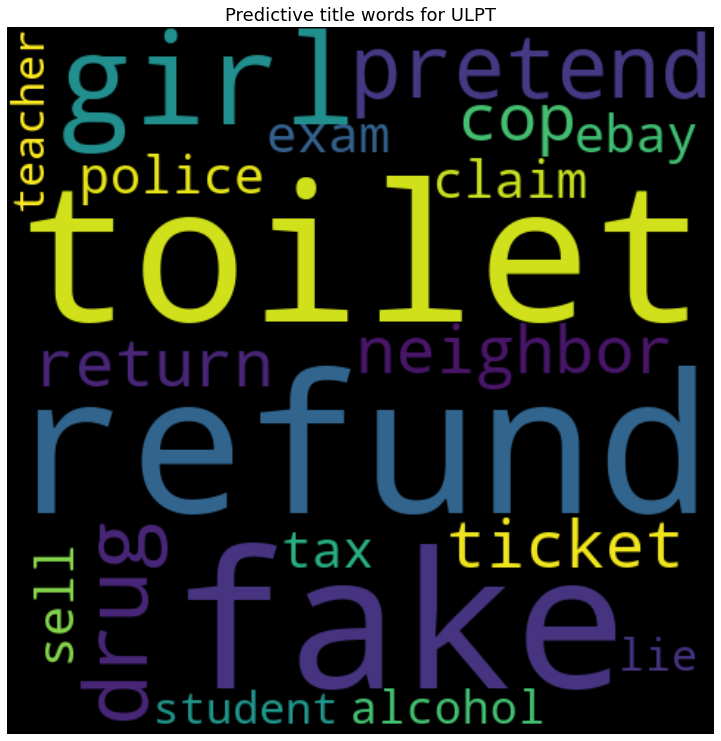

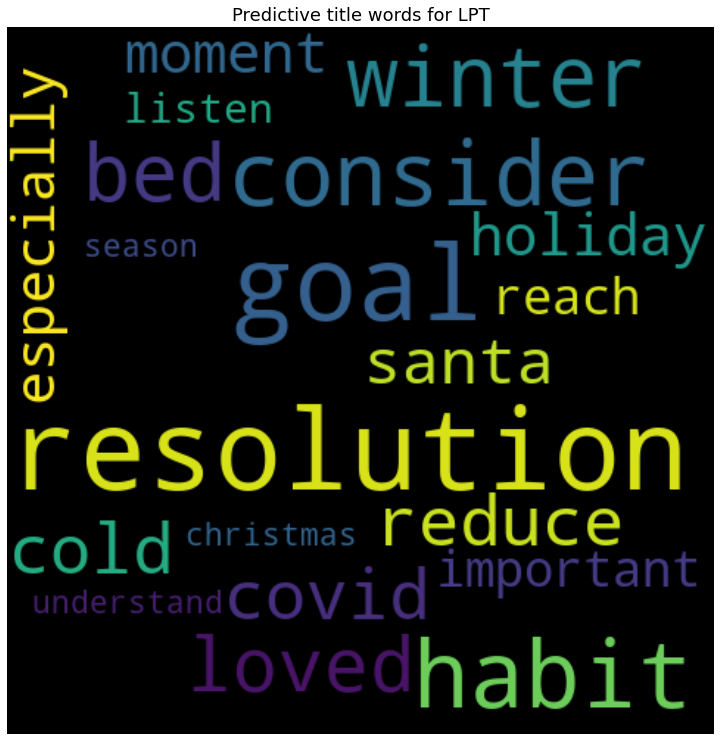

In [34]:
t_vectorizer = CountVectorizer(min_df=25, stop_words='english')

titletraincv = t_vectorizer.fit_transform(titles_train)

titlescv = t_vectorizer.transform(titles)

model = MultinomialNB(.2)
model.fit(titlescv,y)

words = np.array(t_vectorizer.get_feature_names())

x = np.eye(titlescv.shape[1])
probs = model.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:20]]
bad_words = words[ind[-20:]]

good_prob = probs[ind[:20]]
bad_prob = probs[ind[-20:]]

print("Good words\t     P(ULPT | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(ULPT | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

good_word_repeat = []

for word, i in zip(good_words, good_prob):
    prob = 1 - np.exp(i)
    for j in range(int(prob*100)):
        good_word_repeat.append(word)
        
good_word_string = ' '.join(good_word_repeat)

wordcloud = WordCloud(width=480, height=480, collocations=False).generate(good_word_string)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Predictive title words for ULPT', fontsize=18)
plt.savefig('Report/ULPT_title_wordcloud.jpeg')
plt.show()

bad_word_repeat = []

bad_max = max([int((1-np.exp(i))*100) for i in bad_prob])

for word, i in zip(bad_words, bad_prob):
    prob = 1 - np.exp(i)
    for j in range(bad_max - int(prob*100)+1):
        bad_word_repeat.append(word)
        
bad_word_string = ' '.join(bad_word_repeat)

wordcloud = WordCloud(width=480, height=480, collocations=False).generate(bad_word_string)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Predictive title words for LPT', fontsize=18)
plt.savefig('Report/LPT_title_wordcloud.jpeg')
plt.show()

## 4. Modeling<a id='4.'></a>

We will consider the following estimators: `MultinomialNB`, `LogisticRegression`, and `RandomForestClassifier`

First generate the selected vectorized matrix for training and testing:

In [35]:
t_vectorizer = CountVectorizer(min_df=10, stop_words='english')
a_vectorizer = CountVectorizer(min_df=10, stop_words='english')
t_bigrams = CountVectorizer(min_df=10, stop_words='english', ngram_range=(2,2), max_features=3000)
a_bigrams = CountVectorizer(min_df=10, stop_words='english', ngram_range=(2,2), max_features=3000)

titletraincv = t_vectorizer.fit_transform(titles_train)
titletrainbigram = t_bigrams.fit_transform(titles_train)
alltexttraincv = a_vectorizer.fit_transform(alltext_train)
alltexttrainbigram = a_bigrams.fit_transform(alltext_train)


train_matrix = hstack([titletraincv,titletrainbigram,alltexttraincv,alltexttrainbigram,reading_level_train])
train_matrix_MNB = hstack([titletraincv,titletrainbigram,alltexttraincv,alltexttrainbigram])

titletestcv = t_vectorizer.transform(titles_test)
titletestbigram = t_bigrams.transform(titles_test)
alltexttestcv = a_vectorizer.transform(alltext_test)
alltexttestbigram = a_bigrams.transform(alltext_test)

test_matrix = hstack([titletestcv,titletestbigram,alltexttestcv,alltexttestbigram,reading_level_test])
test_matrix_MNB = hstack([titletestcv,titletestbigram,alltexttestcv,alltexttestbigram])


### 4.0. Cross-validation<a id='4.0.'></a>

In [36]:
# RandomizedSearchCV on random forest:

start = time.time()

steps = [('RF', RandomForestClassifier(random_state=2,n_jobs=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]

criteria = ['gini','entropy']

depths = [int(n) for n in np.logspace(start=1, stop=2, num = 20)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,\
             'RF__criterion':criteria, 'RF__max_depth':depths, 'RF__max_features':num_features}

RF_pipe = Pipeline(steps)

RF_cv = RandomizedSearchCV(RF_pipe, param_distributions=RF_params, cv=5, scoring=['accuracy','roc_auc'],refit='accuracy',random_state=2)

RF_cv.fit(train_matrix,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

RF_df = pd.DataFrame(RF_cv.cv_results_)
RF_df.to_csv('CV_results/RF_cv_results.csv')
RF_cv.best_score_

Time elapsed:  248.78222393989563


0.7614514480719748

In [37]:
RF_cv.best_params_

{'RF__n_estimators': 143,
 'RF__max_features': 'log2',
 'RF__max_depth': 78,
 'RF__criterion': 'gini'}

In [38]:
RF_model = RF_cv.best_estimator_
RF_model.fit(train_matrix,y_train)
RF_pred = RF_model.predict(test_matrix)

RF_score = accuracy_score(y_test,RF_pred)
RF_auc = roc_auc_score(y_test,RF_pred)
RF_cm = confusion_matrix(y_test,RF_pred)
print('RF accuracy: ', RF_score)
print('RF auc_roc: ', RF_auc)
print('RF confusion matrix: \n', RF_cm)
print(classification_report(y_test,RF_pred))

RF accuracy:  0.7880875202593193
RF auc_roc:  0.788279413763823
RF confusion matrix: 
 [[ 918  321]
 [ 202 1027]]
              precision    recall  f1-score   support

       False       0.82      0.74      0.78      1239
        True       0.76      0.84      0.80      1229

    accuracy                           0.79      2468
   macro avg       0.79      0.79      0.79      2468
weighted avg       0.79      0.79      0.79      2468



In [39]:
# GridSearchCV MultinomialNB 

start = time.time()

steps = [('MNB', MultinomialNB())]

alphas = [0.01,0.1,0,1,2,5,10]

MNB_params = {'MNB__alpha':alphas}

MNB_pipe = Pipeline(steps)

MNB_cv = GridSearchCV(MNB_pipe, param_grid=MNB_params, cv=5, scoring=['accuracy','roc_auc'],refit='accuracy')

MNB_cv.fit(train_matrix_MNB,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

MNB_df = pd.DataFrame(MNB_cv.cv_results_)
MNB_df.to_csv('CV_results/MNB_cv_results.csv')
MNB_cv.best_score_

Time elapsed:  0.33585095405578613


0.7772541380002554

In [40]:
MNB_cv.best_params_

{'MNB__alpha': 0.1}

In [41]:
MNB_model = MNB_cv.best_estimator_
MNB_model.fit(train_matrix_MNB,y_train)
MNB_pred = MNB_model.predict(test_matrix_MNB)

MNB_score = accuracy_score(y_test,MNB_pred)
MNB_auc = roc_auc_score(y_test,MNB_pred)
MNB_cm = confusion_matrix(y_test,MNB_pred)
print('MNB accuracy: ', MNB_score)
print('MNB auc_roc: ', MNB_auc)
print('MNB confusion matrix: \n', MNB_cm)
print(classification_report(y_test,MNB_pred))

MNB accuracy:  0.7917341977309562
MNB auc_roc:  0.7918128678013386
MNB confusion matrix: 
 [[957 282]
 [232 997]]
              precision    recall  f1-score   support

       False       0.80      0.77      0.79      1239
        True       0.78      0.81      0.80      1229

    accuracy                           0.79      2468
   macro avg       0.79      0.79      0.79      2468
weighted avg       0.79      0.79      0.79      2468



In [42]:
# GridSearchCV LogisticRegression 


start = time.time()

steps = [('LogReg', LogisticRegression())]

penalties = ['l1', 'l2', 'elasticnet', 'none']

duals = [True, False]

tols = [0.0001,0.001,0.01,0.1]

Cs = [0.01,0.1,1,2]

LogReg_params = {'LogReg__penalty':penalties, 'LogReg__dual':duals, 'LogReg__tol':tols, 'LogReg__C':Cs}

LogReg_pipe = Pipeline(steps)

LogReg_cv = GridSearchCV(LogReg_pipe, param_grid=LogReg_params, cv=5, scoring=['accuracy','roc_auc'],refit='accuracy')

LogReg_cv.fit(train_matrix,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

LogReg_df = pd.DataFrame(LogReg_cv.cv_results_)
LogReg_df.to_csv('CV_results/LogReg_cv_results.csv')
LogReg_cv.best_score_

Time elapsed:  42.526227951049805


0.7714425059766046

In [43]:
LogReg_cv.best_params_

{'LogReg__C': 0.1,
 'LogReg__dual': False,
 'LogReg__penalty': 'l2',
 'LogReg__tol': 0.0001}

In [44]:
LogReg_model = LogReg_cv.best_estimator_
LogReg_model.fit(train_matrix,y_train)
LogReg_pred = LogReg_model.predict(test_matrix)

LogReg_score = accuracy_score(y_test,LogReg_pred)
LogReg_auc = roc_auc_score(y_test,LogReg_pred)
LogReg_cm = confusion_matrix(y_test,LogReg_pred)
print('LogReg accuracy: ', LogReg_score)
print('LogReg auc_roc: ', LogReg_auc)
print('LogReg confusion matrix: \n', LogReg_cm)
print(classification_report(y_test,LogReg_pred))

LogReg accuracy:  0.8022690437601296
LogReg auc_roc:  0.8023084839016216
LogReg confusion matrix: 
 [[982 257]
 [231 998]]
              precision    recall  f1-score   support

       False       0.81      0.79      0.80      1239
        True       0.80      0.81      0.80      1229

    accuracy                           0.80      2468
   macro avg       0.80      0.80      0.80      2468
weighted avg       0.80      0.80      0.80      2468



## 4.1. Threshold Tuning<a id='4.1.'></a>

In [45]:
def y_crisp(probs, threshold):
    return (probs >= threshold).astype('int')

In [46]:
def fbeta(pre, rec, beta=1):
    return (1+beta**2)*(pre*rec)/((beta**2)*pre + rec)

In [47]:
def results(clf):
    start = time.time()
    print('Threshold analysis for ', clf.__class__.__name__)
    try:
        yproba = clf.predict_proba(test_matrix)[:,1]
    except:
        yproba = clf.predict_proba(test_matrix_MNB)[:,1]
    
    # plot F scores against thresholds for beta = 0.5, 1, 2
    
    thresh = np.arange(0,1,0.001)
    extraticks = []
    for beta, color, color_plot in zip([0.5, 1, 2],['black','blue','red'], ['grey','green','pink']):
        scores = np.array([fbeta_score(y_test, y_crisp(yproba, t), beta=beta) for t in thresh])
        ix = np.argmax(scores)
        best_thresh = thresh[ix]
        print('Best threshold for F_%s: %s'%(beta,best_thresh))
        plt.plot(thresh,scores, c = color_plot, label='F%s scores'%beta)
        plt.axvline(x=best_thresh, label='Best threshold for F_%s'%(beta), c=color)
        
        
        
        extraticks.append(best_thresh)
    
    plt.title('%s F-scores (ULPT)'%(clf.__class__.__name__), fontsize=18)
    plt.legend(loc='upper right', fontsize=18)
    plt.xlabel('thresholds', fontsize=18)
    plt.ylabel('F scores', fontsize=18)
#     plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1] + extraticks, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.savefig('Report/%s_F-scores.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    # plot thresholds on precision-recall curve
    
    precision, recall, thresholds = precision_recall_curve(y_test, yproba)
    # convert to f score

    fhalfscore = fbeta(precision,recall,beta=0.5)
    f1score = fbeta(precision,recall)
    f2score = fbeta(precision,recall,beta=2)

    #fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ixhalf = np.nanargmax(fhalfscore)
    ix1 = np.nanargmax(f1score)
    ix2 = np.nanargmax(f2score)
    print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
    print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
    print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

    # plot the precision-recall curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='model')
    plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
    plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
    plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
    # axis labels
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision-Recall curve for %s (ULPT)'%(clf.__class__.__name__), fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    # show the plot
    plt.savefig('Report/%s_precision_recall.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    # plot best gmean on ROC curve
    
    fpr, tpr, thresholds_roc = roc_curve(y_test, yproba)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_roc[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='%s'%(clf.__class__.__name__))
    plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best', markersize=10)
    # axis labels
    plt.title('best G-mean for %s (ULPT)'%(clf.__class__.__name__), fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # show the plot
    plt.savefig('Report/%s_ROC_curve.jpeg'%(clf.__class__.__name__))
    plt.show()
    
    print('ROC AUC score: ', roc_auc_score(y_test,yproba))
    
    # print out confusion matrices and classification reports
    
    good_thresholds = zip(['F_0.5', 'F_1', 'F_2', 'Gmeans'],[thresholds[ixhalf],thresholds[ix1],thresholds[ix2], thresholds_roc[ix]])

    for name, t in good_thresholds:
        y_pred = y_crisp(yproba,t)
        print('Threshold for ', name,': ', t)
        print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
        print('Classification report:\n', classification_report(y_test, y_pred))
    end = time.time()
    print('Time elapsed: ', end-start)

In [48]:
models = {'MNB':MultinomialNB(alpha=1),
          'RF':RandomForestClassifier(n_estimators=143, max_features='log2', max_depth=78, criterion='gini', random_state=2),
          'LogReg': LogisticRegression(C=0.1, dual=False, penalty='l2', tol = 0.0001)}

for clf in list(models.values()):
    try:
        clf.fit(train_matrix,y_train)
    except:
        clf.fit(train_matrix_MNB,y_train)

Threshold analysis for  MultinomialNB
Best threshold for F_0.5: 0.528
Best threshold for F_1: 0.106
Best threshold for F_2: 0.004


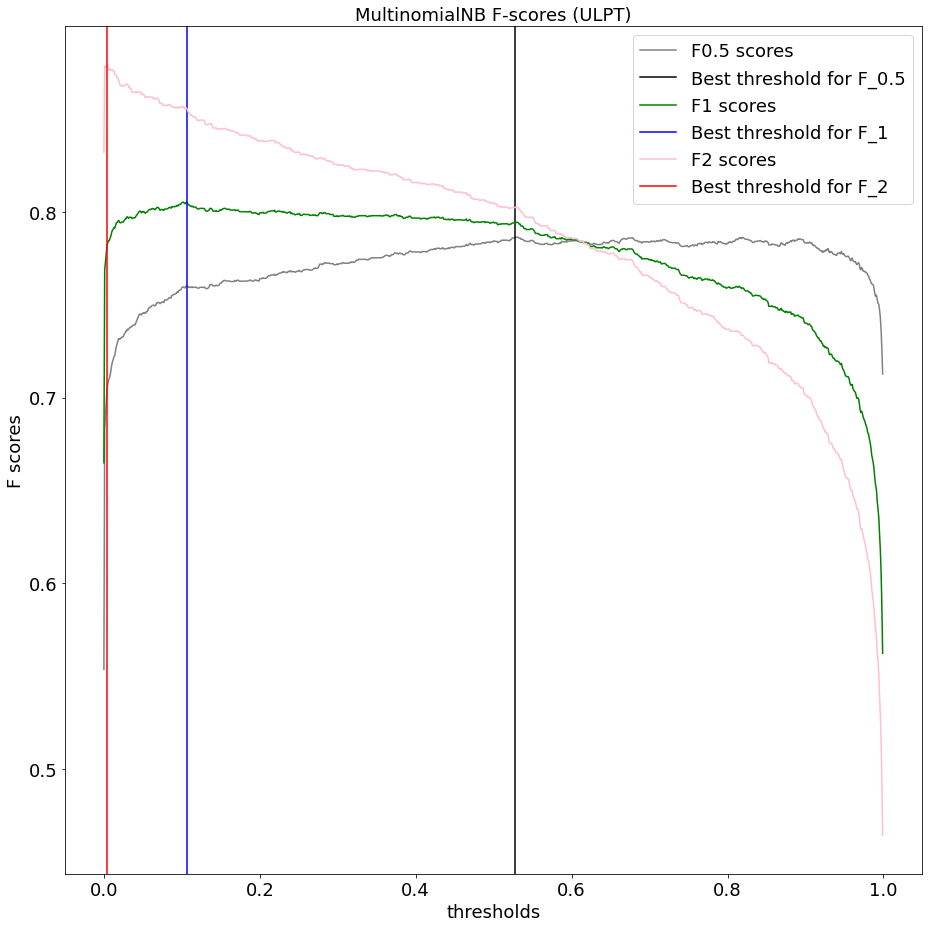

Best Threshold for F_0.5: 0.531892, F_0.5-Score=0.786
Best Threshold for F_1: 0.106573, F_1-Score=0.805
Best Threshold for F_2: 0.004664, F_2-Score=0.880


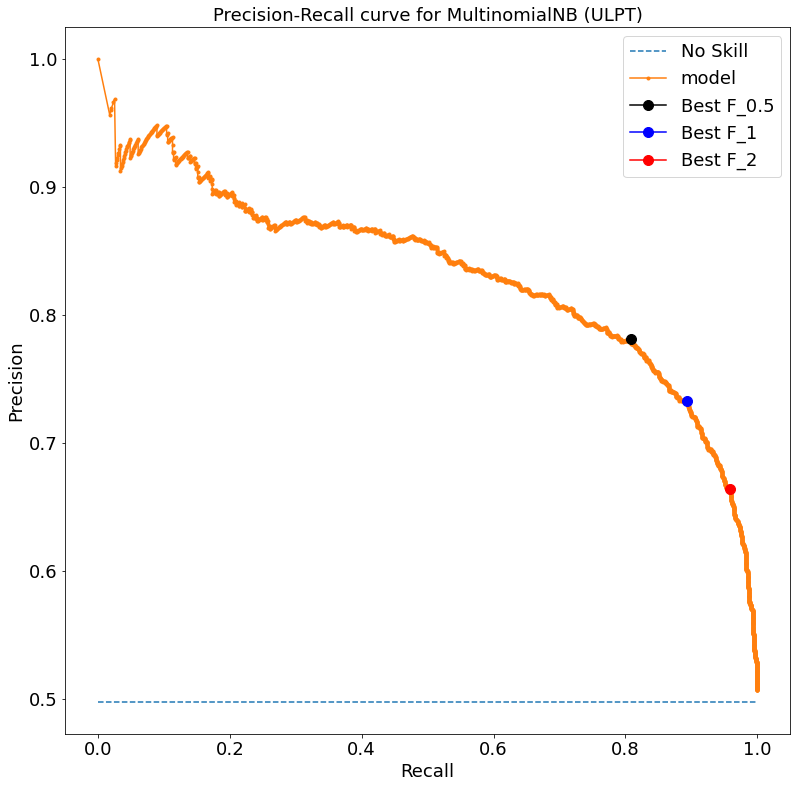

Best Threshold=0.531892, G-Mean=0.792


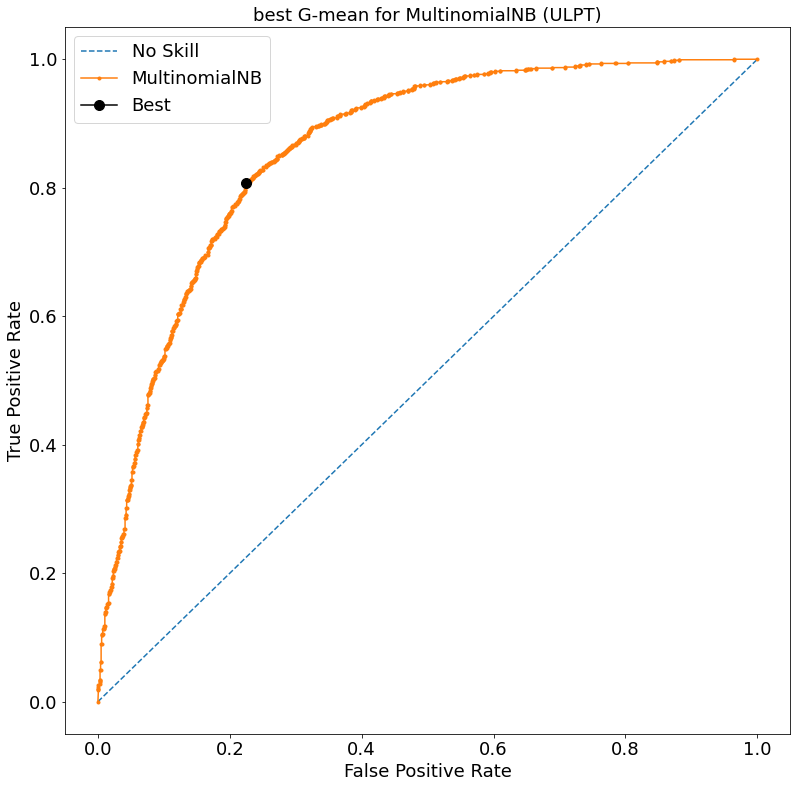

ROC AUC score:  0.8602615957775863
Threshold for  F_0.5 :  0.531891525901667
Confusion matrix: 
 [[961 278]
 [236 993]]
Classification report:
               precision    recall  f1-score   support

       False       0.80      0.78      0.79      1239
        True       0.78      0.81      0.79      1229

    accuracy                           0.79      2468
   macro avg       0.79      0.79      0.79      2468
weighted avg       0.79      0.79      0.79      2468

Threshold for  F_1 :  0.10657337879544673
Confusion matrix: 
 [[ 839  400]
 [ 131 1098]]
Classification report:
               precision    recall  f1-score   support

       False       0.86      0.68      0.76      1239
        True       0.73      0.89      0.81      1229

    accuracy                           0.78      2468
   macro avg       0.80      0.79      0.78      2468
weighted avg       0.80      0.78      0.78      2468

Threshold for  F_2 :  0.004664435021198674
Confusion matrix: 
 [[ 643  596]
 [  51 1178]]

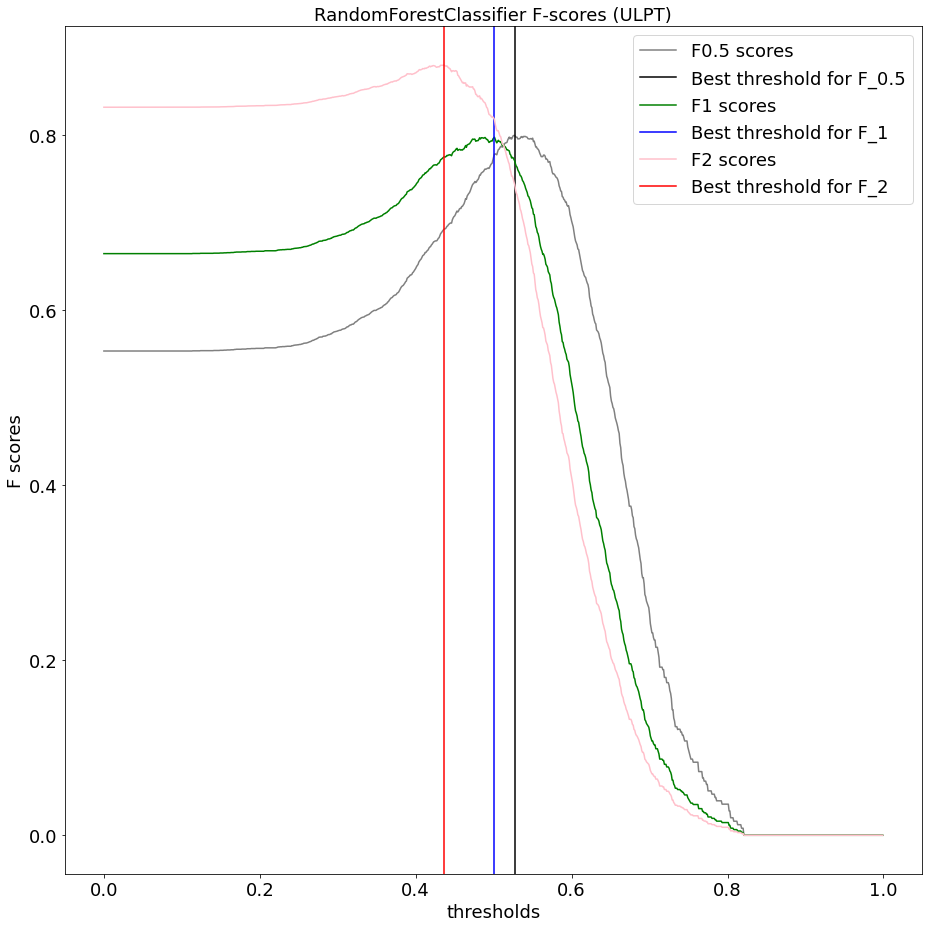

Best Threshold for F_0.5: 0.526582, F_0.5-Score=0.800
Best Threshold for F_1: 0.500851, F_1-Score=0.799
Best Threshold for F_2: 0.436289, F_2-Score=0.881


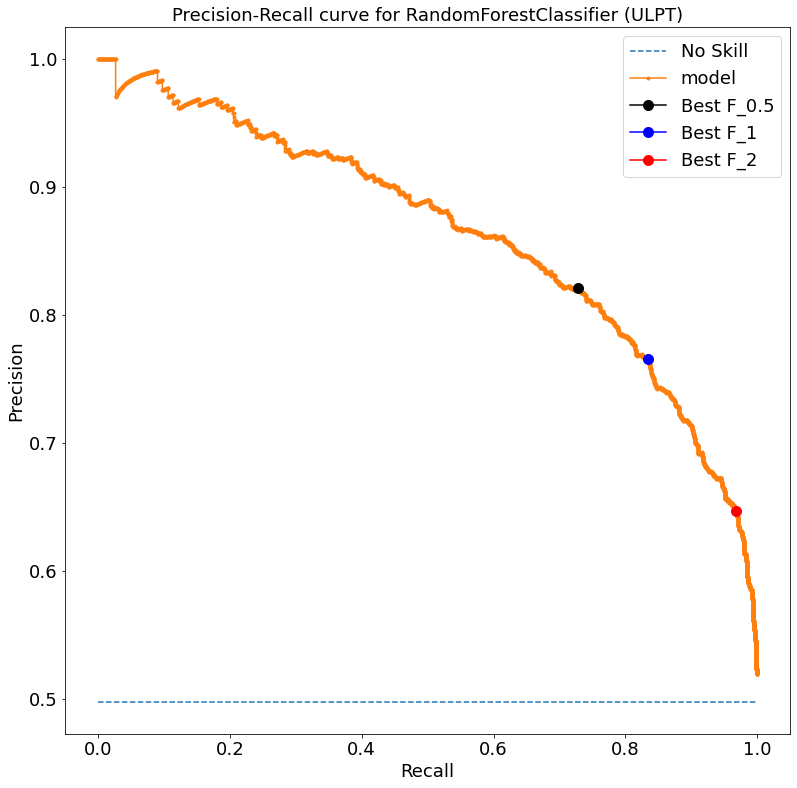

Best Threshold=0.506540, G-Mean=0.792


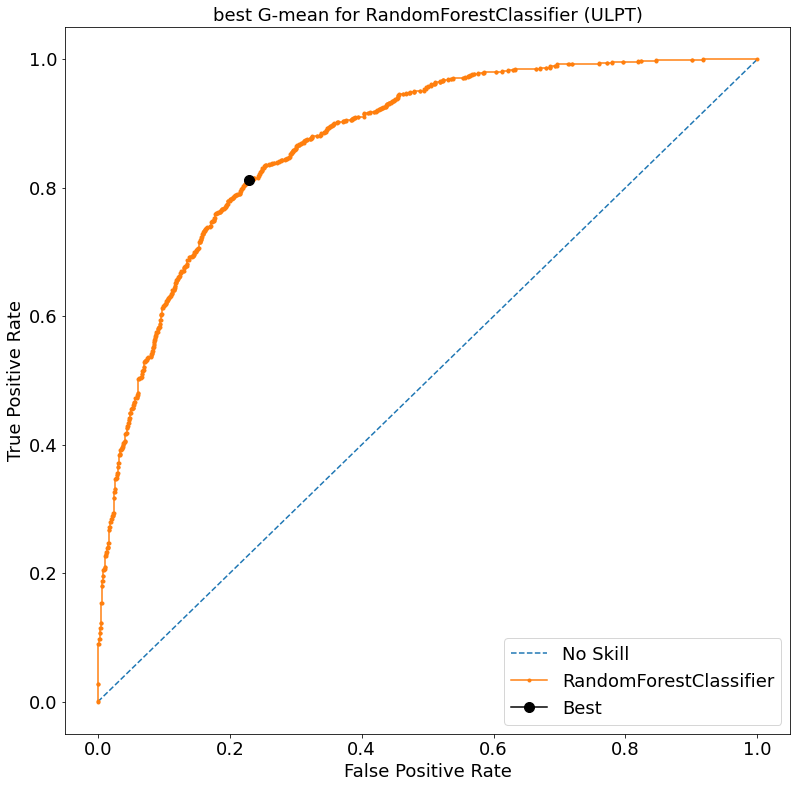

ROC AUC score:  0.8720187610287042
Threshold for  F_0.5 :  0.526581613675652
Confusion matrix: 
 [[1044  195]
 [ 335  894]]
Classification report:
               precision    recall  f1-score   support

       False       0.76      0.84      0.80      1239
        True       0.82      0.73      0.77      1229

    accuracy                           0.79      2468
   macro avg       0.79      0.79      0.78      2468
weighted avg       0.79      0.79      0.78      2468

Threshold for  F_1 :  0.5008505797001459
Confusion matrix: 
 [[ 925  314]
 [ 203 1026]]
Classification report:
               precision    recall  f1-score   support

       False       0.82      0.75      0.78      1239
        True       0.77      0.83      0.80      1229

    accuracy                           0.79      2468
   macro avg       0.79      0.79      0.79      2468
weighted avg       0.79      0.79      0.79      2468

Threshold for  F_2 :  0.4362888864722272
Confusion matrix: 
 [[ 590  649]
 [  39 1190]

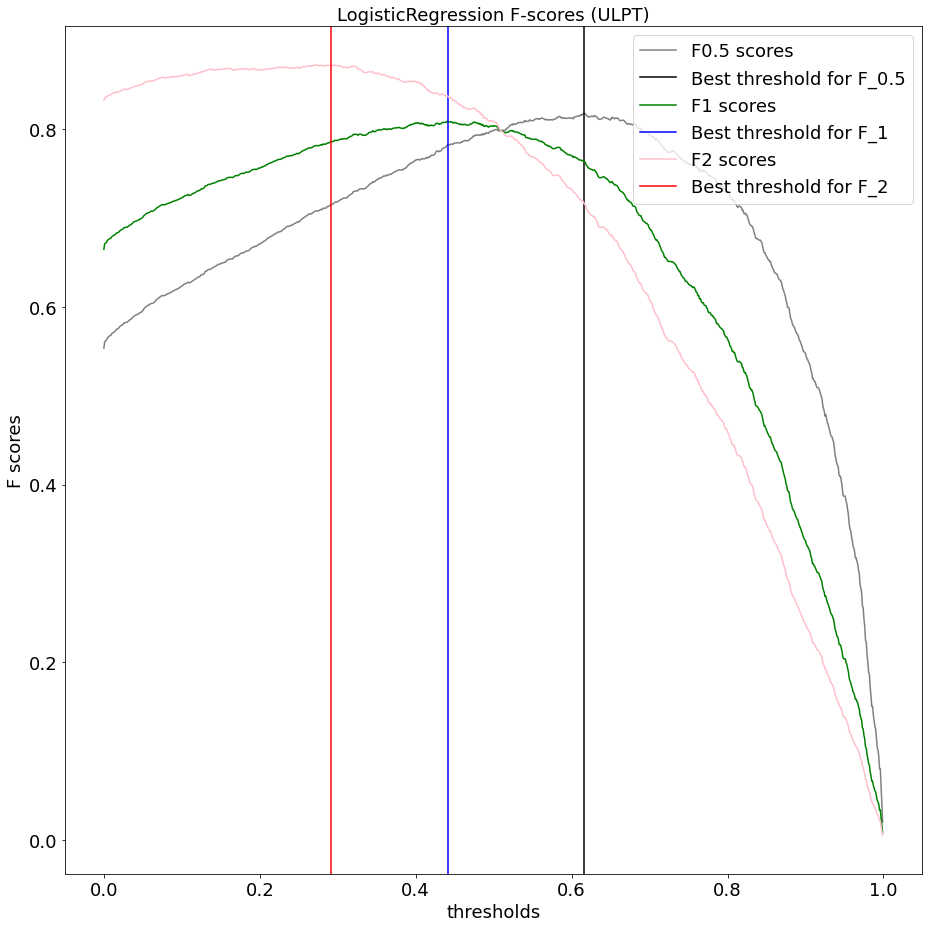

Best Threshold for F_0.5: 0.615669, F_0.5-Score=0.818
Best Threshold for F_1: 0.441154, F_1-Score=0.809
Best Threshold for F_2: 0.273459, F_2-Score=0.873


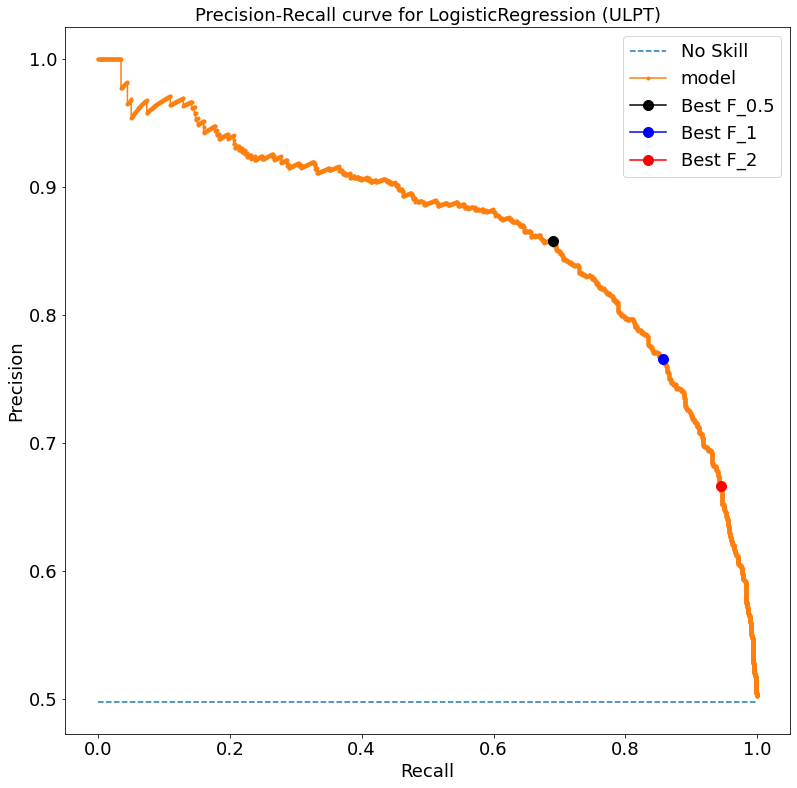

Best Threshold=0.501674, G-Mean=0.803


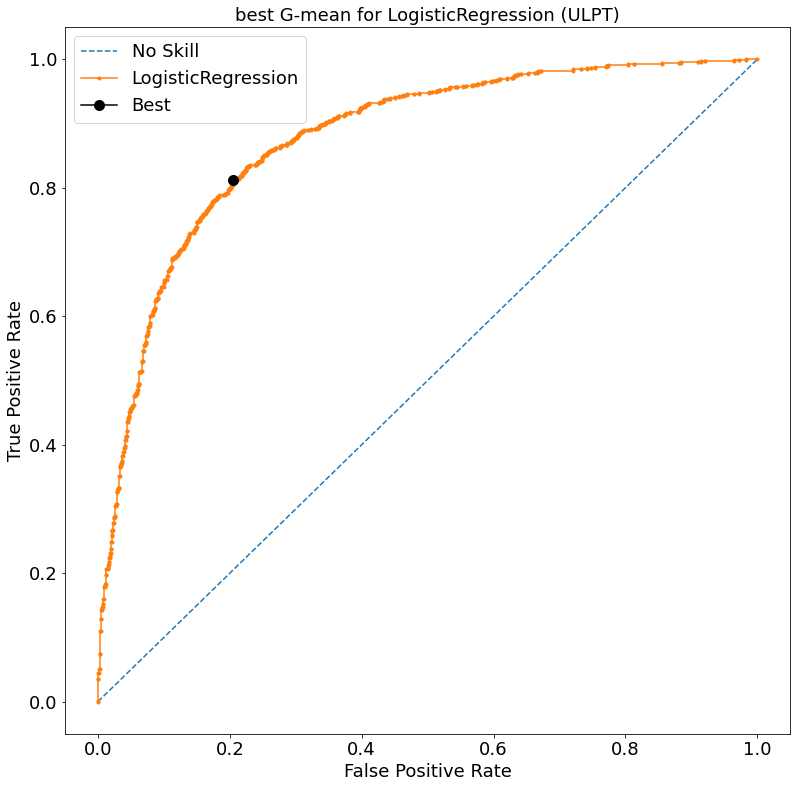

ROC AUC score:  0.8756845431005214
Threshold for  F_0.5 :  0.6156686444728636
Confusion matrix: 
 [[1099  140]
 [ 381  848]]
Classification report:
               precision    recall  f1-score   support

       False       0.74      0.89      0.81      1239
        True       0.86      0.69      0.76      1229

    accuracy                           0.79      2468
   macro avg       0.80      0.79      0.79      2468
weighted avg       0.80      0.79      0.79      2468

Threshold for  F_1 :  0.4411541874871953
Confusion matrix: 
 [[ 917  322]
 [ 175 1054]]
Classification report:
               precision    recall  f1-score   support

       False       0.84      0.74      0.79      1239
        True       0.77      0.86      0.81      1229

    accuracy                           0.80      2468
   macro avg       0.80      0.80      0.80      2468
weighted avg       0.80      0.80      0.80      2468

Threshold for  F_2 :  0.2734585987152601
Confusion matrix: 
 [[ 658  581]
 [  67 1162

In [49]:
for clf in list(models.values()):
    results(clf)

In [50]:
# finding threshold for max recall with precision above 0.89
    
for clf in list(models.values()):
    try:
        yproba = clf.predict_proba(test_matrix)[:,1]
    except: 
        yproba = clf.predict_proba(test_matrix_MNB)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, yproba)
    for i in range(len(recall)):
        if precision[i] < 0.9:
            recall[i] = -1
    ix = np.argmax(recall)
    print('Results for %s:'%(clf))
    print('--Precision: %s'%(precision[ix]))
    print('--Recall: %s'%(recall[ix]))
    print('--Threshold: %s'%(thresholds[ix]))
    
    precision, recall, thresholds = precision_recall_curve(y_test, yproba)
    for i in range(len(recall)):
        if precision[i] < 0.89:
            recall[i] = -1
    ix = np.argmax(recall)
    print('Results for %s:'%(clf))
    print('--Precision: %s'%(precision[ix]))
    print('--Recall: %s'%(recall[ix]))
    print('--Threshold: %s'%(thresholds[ix]))
    

    

Results for MultinomialNB(alpha=1):
--Precision: 0.902542372881356
--Recall: 0.17331163547599673
--Threshold: 0.999998936105695
Results for MultinomialNB(alpha=1):
--Precision: 0.8912280701754386
--Recall: 0.20667209113100082
--Threshold: 0.9999955720899982
Results for RandomForestClassifier(max_depth=78, max_features='log2', n_estimators=143,
                       random_state=2):
--Precision: 0.9001610305958132
--Recall: 0.4548413344182262
--Threshold: 0.5806637746670225
Results for RandomForestClassifier(max_depth=78, max_features='log2', n_estimators=143,
                       random_state=2):
--Precision: 0.8903318903318903
--Recall: 0.5020341741253052
--Threshold: 0.571886953922783
Results for LogisticRegression(C=0.1):
--Precision: 0.9003215434083601
--Recall: 0.45565500406834825
--Threshold: 0.7685995867734129
Results for LogisticRegression(C=0.1):
--Precision: 0.8900602409638554
--Recall: 0.4808787632221318
--Threshold: 0.7524363360734614


[[1163   76]
 [ 612  617]]
              precision    recall  f1-score   support

       False       0.66      0.94      0.77      1239
        True       0.89      0.50      0.64      1229

    accuracy                           0.72      2468
   macro avg       0.77      0.72      0.71      2468
weighted avg       0.77      0.72      0.71      2468

Best Threshold for F_0.5: 0.526582, F_0.5-Score=0.800
Best Threshold for F_1: 0.500851, F_1-Score=0.799
Best Threshold for F_2: 0.436289, F_2-Score=0.881


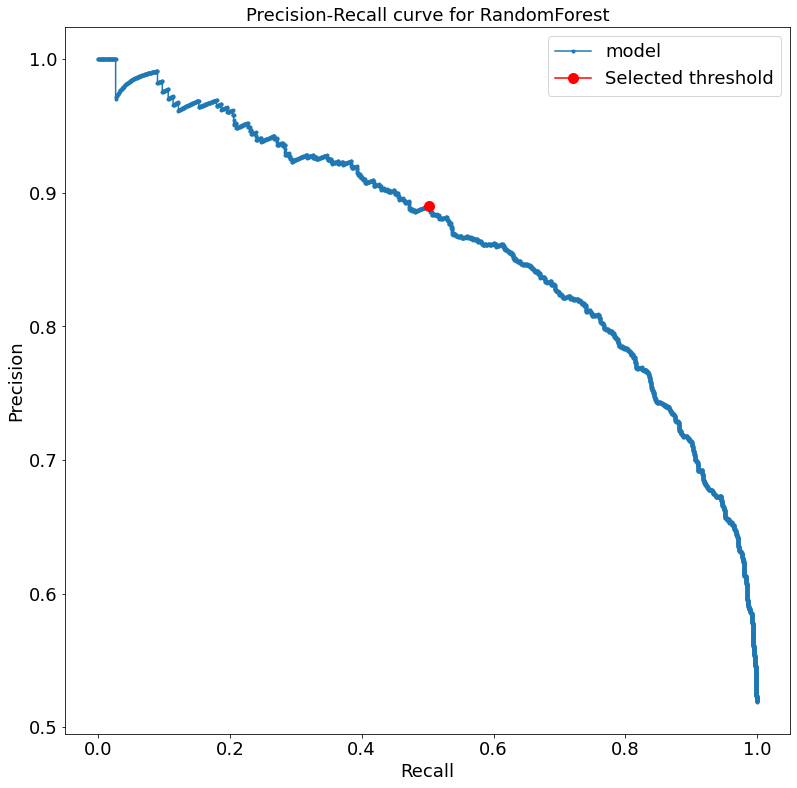

In [51]:
thresh = 0.571886953922783
yproba = models['RF'].predict_proba(test_matrix)[:,1]
y_pred = y_crisp(yproba, thresh)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

precision, recall, thresholds = precision_recall_curve(y_test, yproba)
for i in range(len(recall)):
    if precision[i] < 0.89:
        recall[i] = -1
ix = np.argmax(recall)

precision, recall, thresholds = precision_recall_curve(y_test, yproba)
# convert to f score

fhalfscore = fbeta(precision,recall,beta=0.5)
f1score = fbeta(precision,recall)
f2score = fbeta(precision,recall,beta=2)

#fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ixhalf = np.nanargmax(fhalfscore)
ix1 = np.nanargmax(f1score)
ix2 = np.nanargmax(f2score)
print('Best Threshold for F_0.5: %f, F_0.5-Score=%.3f' % (thresholds[ixhalf], fhalfscore[ixhalf]))
print('Best Threshold for F_1: %f, F_1-Score=%.3f' % (thresholds[ix1], f1score[ix1]))
print('Best Threshold for F_2: %f, F_2-Score=%.3f' % (thresholds[ix2], f2score[ix2]))

# plot the precision-recall curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
# plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='model')
# plt.plot(recall[ixhalf], precision[ixhalf], marker='o', color='black', label='Best F_0.5', markersize=10)
# plt.plot(recall[ix1], precision[ix1], marker='o', color='blue', label='Best F_1',markersize=10)
# plt.plot(recall[ix2], precision[ix2], marker='o', color='red', label='Best F_2',markersize=10)
plt.plot(recall[ix], precision[ix], marker='o', color='red', label='Selected threshold',markersize=10)
# axis labels
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve for %s'%('RandomForest'), fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
# show the plot
plt.savefig('Report/%s_precision_recall.jpeg'%('RF'))
plt.show()

## 5. Model production<a id='5.'></a>

### 5.0. Saving relevant files<a id='5.0.'></a>

Fit vectorizers for entire dataset.  Save each vectorizer using `pickle` module.

In [52]:
t_vectorizer = CountVectorizer(min_df=10, stop_words='english')
a_vectorizer = CountVectorizer(min_df=10, stop_words='english')
t_bigrams = CountVectorizer(min_df=10, stop_words='english', ngram_range=(2,2), max_features=3000)
a_bigrams = CountVectorizer(min_df=10, stop_words='english', ngram_range=(2,2), max_features=3000)

titlecv = t_vectorizer.fit_transform(titles)
pickle.dump(t_vectorizer, open("Pickled/t_vectorizer.pickle", "wb"))

titlebigram = t_bigrams.fit_transform(titles)
pickle.dump(t_bigrams, open("Pickled/t_bigrams.pickle", "wb"))

alltextcv = a_vectorizer.fit_transform(alltext)
pickle.dump(a_vectorizer, open("Pickled/a_vectorizer.pickle", "wb"))

alltextbigram = a_bigrams.fit_transform(alltext)
pickle.dump(a_bigrams, open("Pickled/a_bigrams.pickle", "wb"))



matrix = hstack([titlecv,titlebigram,alltextcv,alltextbigram,reading_level])

Fit model on entire dataset.  Save trained model using `pickle` module.

In [53]:
model = RandomForestClassifier(n_estimators=143, max_features='log2', max_depth=78, criterion='gini', random_state=2)

model.fit(matrix, y)
pickle.dump(model, open('Pickled/ethics_model.pickle', 'wb'))

### 5.1. Script for prediction function<a id='5.1.'></a>

In [54]:
import re
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from textstat import flesch_kincaid_grade
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import pickle

In [55]:
model = pickle.load(open('Pickled/ethics_model.pickle', 'rb'))

t_vectorizer = pickle.load(open("Pickled/t_vectorizer.pickle", "rb"))

t_bigrams = pickle.load(open("Pickled/t_bigrams.pickle", "rb"))

a_vectorizer = pickle.load(open("Pickled/a_vectorizer.pickle", "rb"))

a_bigrams = pickle.load(open("Pickled/a_bigrams.pickle", "rb"))

thresh = 0.571886953922783

In [56]:
def preprocess(s):
    """This function converts a string to lowercase, removes punctuation, and removes opening/trailing whitespaces"""
    # convert string s to lowercase
    out = s.lower()
    # remove punctuation
    out = re.sub(r'[^\w\s]','',out)
    # remove opening/trailing whitespace
    out = out.strip()
    return out

In [57]:
def lemmatize(text):
    """This function lemmatizes the string text"""
    lemmatizer = WordNetLemmatizer()
    tokenized = word_tokenize(text)
    lemma = [lemmatizer.lemmatize(word) for word in tokenized]
    lemmatized_text = ' '.join(lemma)
    return lemmatized_text

In [58]:
def predict_ethics(advice):
    """Function returns prediction on whether the string variable advice
    is ethical or not based the traine RandomForestClassifier estimator."""
    
    # preprocess and lemmatize the string
    
    advice = preprocess(advice)
    advice = lemmatize(advice)
    
    
    # obtain necessary series
    title = pd.Series([advice])
    alltext = pd.Series([advice])
    
    # vectorize using the trained vectorizers
    vectorized_title = t_vectorizer.transform(title)
    bigram_title = t_bigrams.transform(title)
    vectorized_alltext = a_vectorizer.transform(alltext)
    bigram_alltext = a_bigrams.transform(alltext)
    
    # obtain reading level
    RL = np.array([flesch_kincaid_grade(advice)]).reshape(-1,1)
    
    # form input matrix
    input_matrix = hstack([vectorized_title,bigram_title,vectorized_alltext,bigram_alltext,RL])
    
    proba = model.predict_proba(input_matrix)[0,1]
    
    print('Unethical score: ', proba)
    
    if proba >= thresh:
        print('This advice is unethical')
        return True
    else:
        print('This advice is not unethical')
        return False

In [59]:
_ = predict_ethics("fake an illness to get out of work")

Unethical score:  0.671753170688538
This advice is unethical
